In [275]:
import numpy as np
from last_week import same
from numpy import ndarray
from numpy.typing import ArrayLike

In [276]:
Kmat = np.load("Chladni-Kmat.npy")

Implement centers,radii = gershgorin(A)

In [277]:
def gershgorin(A : ArrayLike) -> (ndarray, ndarray):
    centers = np.diag(A)

    radii = np.zeros(A.shape[0])
    for i in range(A.shape[0]):
        radii[i] = np.sum(np.abs(A[i,:])) - np.abs(A[i,i])
        
    return centers, radii

Localize the eigenvalues of K, and report the disk centers and radii

In [278]:
gershgorin(Kmat)

(array([1.29292219e+05, 1.03041439e+05, 6.49675787e+04, 4.36124119e+04,
        3.62737515e+04, 3.79900994e+04, 2.41669711e+04, 1.16511587e+04,
        1.38650805e+04, 5.60054767e+03, 1.17303879e+03, 1.76077135e+03,
        2.88423061e+02, 8.68968906e+01, 1.38933458e+01]),
 array([4.22316467e+04, 5.69275189e+04, 3.11606709e+04, 1.85323487e+04,
        7.87051614e+03, 1.78547026e+04, 1.54147167e+04, 2.51204139e+03,
        5.50296953e+03, 1.19528329e+03, 3.41990248e+02, 4.01214726e+02,
        7.14173194e+01, 2.54029437e+00, 2.59094641e-01]))

Implement a function lambda = rayleigh_qt(A,x),

In [279]:
def rayleigh_qt(A : ArrayLike,x : ArrayLike) -> float:
    _lambda = x.T @ A @ x/(x.T @ x)
    return _lambda

Implement a function x, k = power iterate(A,x0) for power iteration. Don’t forget to choose and implement a suitable convergence criterion

In [280]:
def power_iterate(A : ArrayLike, x0 : ArrayLike) -> (ndarray, int):
    x0 = x0.copy()
    for k in range(10000):
        ls = x0.copy()
        x0 = A @ x0

        # normalize?
        x0 = x0/np.linalg.norm(x0)

        if (np.linalg.norm(x0 - ls) < 1e-8):
            break

    return x0, k

Test it by finding the largest eigenvalue of the example matrices. Report the eigenvalue found, the Rayleigh residual (the residual of the Raleigh quotient as a least-squares system), and the number k of iterations used. 

In [281]:
from Project2_examplematrices import *

examples = [A1, A2, A3, A4, A5, A6]
example_answers = [eigvals1, eigvals2, eigvals3, eigvals4, eigvals5, eigvals6]

for A, ans in zip(examples, example_answers):
    centers, radii = gershgorin(A)

    x, k = power_iterate(A, centers)
    lambd = rayleigh_qt(A, x)
    print(same(lambd, ans[0]))
    

# TODO: print the right stuff


True
True
True
True
True
True


What is the largest eigenvalue of K? Visualize your eigenfunction using show waves(x,basis set) to see the wave, and show nodes(x,basis set) to see where the sand will gather. The eigenfunction for the largest eigenvalue should have nodes along an 8 x 8 grid. 

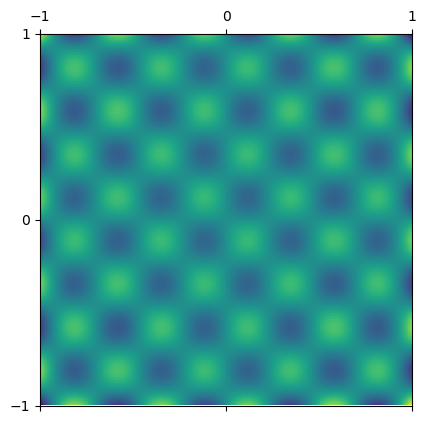

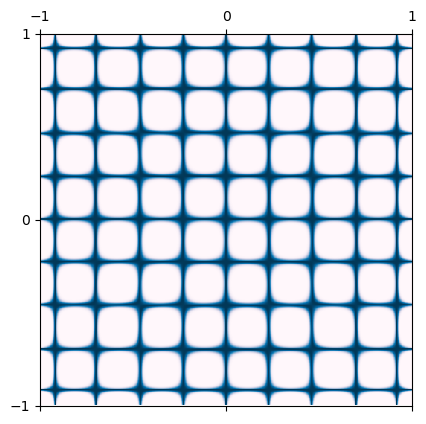

In [282]:
from chladni_show import show_waves, show_nodes
A = Kmat

centers, radii = gershgorin(A)

x, k = power_iterate(A, centers)

lambd = rayleigh_qt(A, x)
show_waves(x)
show_nodes(x)


Write a Rayleigh quotient iteration function x, k = rayleigh iterate(A,x0, shift0), which takes a matrix A, an initial vector x0, and an approximate eigenvalue shift0 as arguments and returns an eigenvector x together with the number k of iterations used. The multiplication by the inverse matrix should be implemented using either your own LUfactorization from as x = lu solve(A,y) or QR-factorization from as x = qr solve(A,y). NB: If you did not get either to work in previous weeks, you can use an in-built linear solver and make a small note that you do this.

In [311]:
from last_week import solve_least_squares as lu_solve

def check_eigs(M, eigs):
    sames = []
    for a,b in zip(np.linalg.eig(M)[0],np.sort(k_eigs[1])[::-1]):
        sames.append(same(a,b))

    return all(sames)


# Define function to get rayleigh residual
def rayleigh_residual(A, x, eigval): 
    return np.linalg.norm(A@x - eigval*x)

    

def rayleigh_iterate(A : ArrayLike, x0 : ArrayLike, shift0 : float) -> (ndarray, int, float):
    x = x0.copy()
    shift = shift0


    # Few steps of shifted inverse to make sure x is an approximate eigenvector
    for i in range(5):
        # Generate next vector
        matrix = A - shift * np.identity(A.shape[0])
        y = lu_solve(matrix,x) #np.linalg.solve(matrix, x) #could use plu factorize
        
        # Normalize
        x = y / np.sqrt( np.sum(y**2) ) 

    for k in range(10000):
        x = lu_solve(A - shift * np.eye(A.shape[0]), x)

        # normalize?
        x = x/np.linalg.norm(x)

        shift = rayleigh_qt(A, x)

        residual = rayleigh_residual(A,x,shift)
        if (residual < 1e-8):
            break

    return x0, k, shift

def get_eigs(M):
    centers, radii = gershgorin(M)
    found_vecs = []
    found_vals = []
    for c, r in zip(centers, radii):
        search_space = np.linspace(c - r, c + r, 10)
        search_space = np.append(search_space[5:], search_space[:5])
        good = False
        for initial in search_space:
            eigenvec, k, eigenval = rayleigh_iterate(M, np.ones(M.shape[0]), initial)

            if (np.abs(eigenval - c) < r) and not any([same(eigenval, v) for v in found_vals]):
                good = True
                break

        assert good, "No eigenvalue found for "+ str(c)
        assert np.abs(eigenval - c) < r, "Too far from center"
        found_vecs.append(eigenvec)
        found_vals.append(eigenval)

    assert check_eigs(M, found_vals), "Not all eigenvalues found"

    return found_vecs, found_vals

k_eigs = get_eigs(Kmat)



Test it with the example matrices, and report the eigenvalues found, Rayleigh residual, and the number k of iterations used. 

In [308]:
check_eigs(Kmat, k_eigs)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


An important feature of inverse iteration and Rayleigh-iteration is the ability to calculate any eigenvalue and its eigenvectors: given an approximate starting point, we obtain an eigenvector to the nearest eigenvalue. Why can you not get all the eigenvalues and -vectors with pure poweriteration?

S

(2) Use your Rayleigh quotient iteration function together with the Gershgorin centers to calculate as many eigenvectors and eigenvalues of K as you can. Are you able to get all of them? Why? If not, find the remaining one(s) by any means necessary. Check using show nodes(x,basis set) that the eigenfunction with lowest eigenvalue looks like a cross: 

Help on function power_iterate in module __main__:

power_iterate(A: Union[numpy._typing._array_like._SupportsArray[numpy.dtype], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]], x0: Union[numpy._typing._array_like._SupportsArray[numpy.dtype], numpy._typing._nested_sequence._NestedSequence[numpy._typing._array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy._typing._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]]) -> (<class 'numpy.ndarray'>, <class 'int'>)



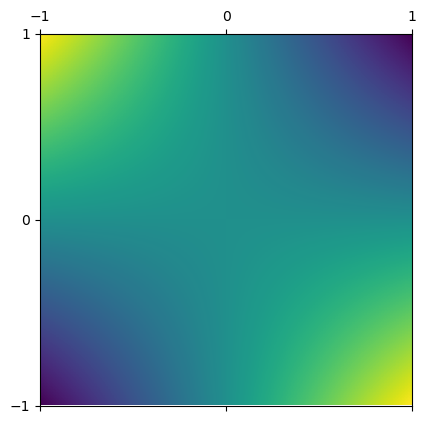

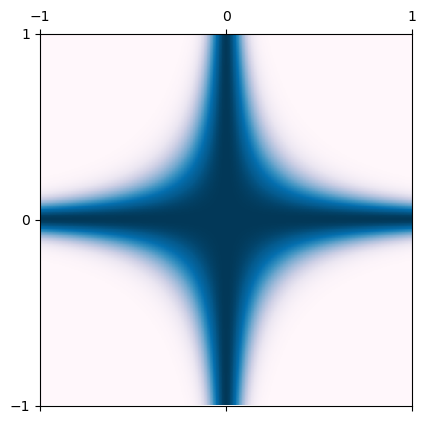

In [ ]:
centers, radii = gershgorin(Kmat)

# xx, kk = power_iterate(Kmat, np.ones(Kmat.shape[0]))



found = []
for center, radius in zip(centers, radii):
    
    for search in np.linspace(center - radius, center + radius, 20):
        x, k, l = rayleigh_iterate(Kmat, np.ones(Kmat.shape[0]), search)

        if not any([same(x, f) for f in found]):
            break

    i += 1
    found.append(x)
    

show_waves(x)
show_nodes(x)

    

(3) Construct the transformation matrix T whose columns are the eigenvectors in order of ascending eigenvalues, and check that $K = T\Lambda T^{-1}$ with diagonal $\Lambda$ (4) Visualize your solution using the provided function show all wavefunction nodes(T,lambdas,basis set).

In [ ]:
def get_T(A):
    T = np.zeros(A.shape)
    found = []
    i = 0
    lambdas = np.empty(A.shape[0])

    centers, radii = gershgorin(A.copy())

    for center, radius in zip(centers, radii):
        
        for search in np.linspace(center - radius, center + radius, 20):
            x, k = rayleigh_iterate(Kmat, np.ones(Kmat.shape[0]), search)

            if not any([same(x, f) for f in found]):
                lambdas[i] = search
                break

        found.append(x)
        T[:,i] = x
        i += 1
        
    return T, lambdas

T, lambdas = get_T(Kmat)


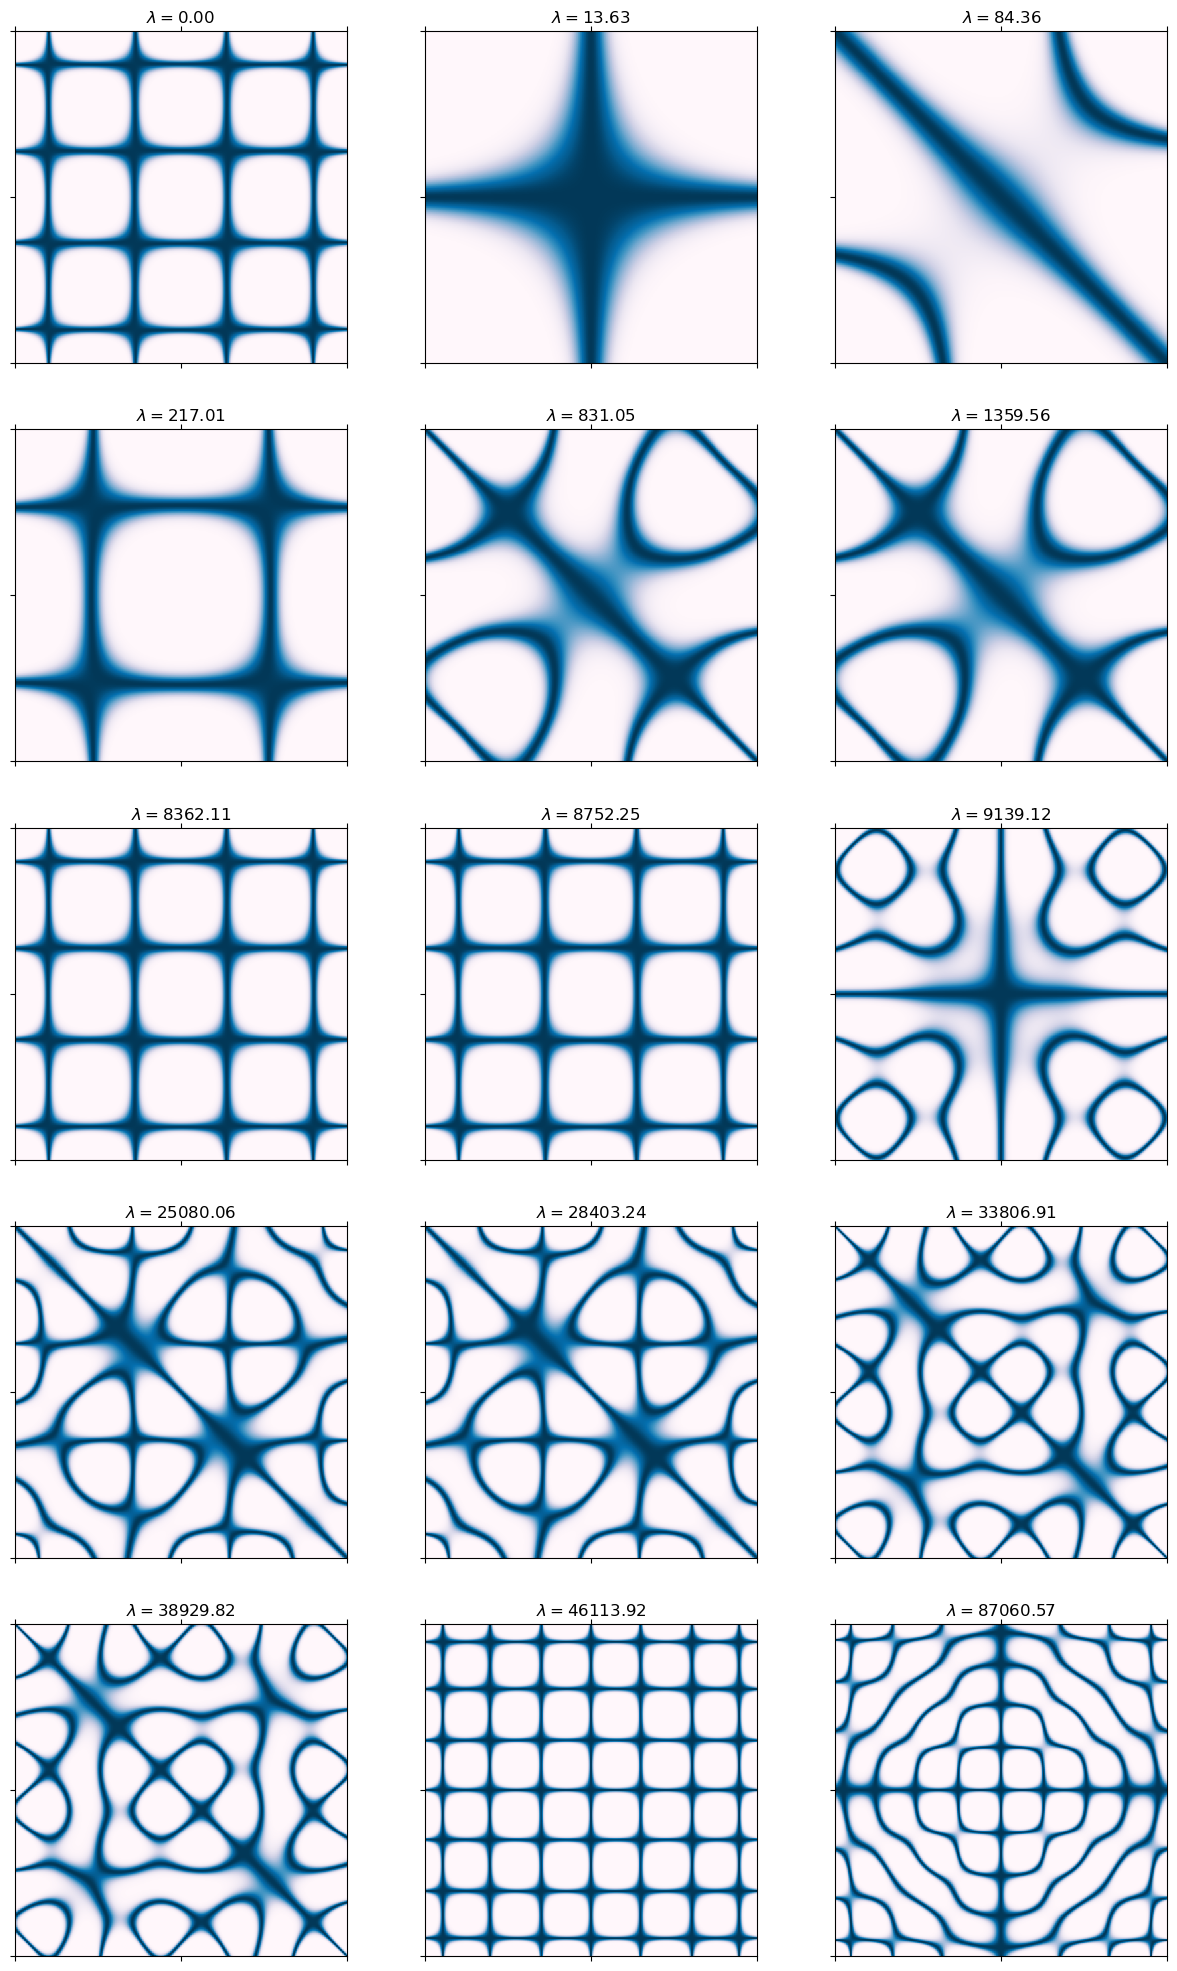

In [ ]:
from chladni_show import show_all_wavefunction_nodes

show_all_wavefunction_nodes(T, lambdas)